# Catastrophic forgetting in MLPs and KANs
## Datasets
* Simple symbolic regression with successive Gauss curves on x
* Wine quality dataset 
## Methods
* Feature permutation
* Incremental class learning

In [360]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Symbolic regression

### Data generation

In [361]:
import torch
import matplotlib.pyplot as plt
from torch import nn

def gaussian(X, center, std_dev):
  return torch.exp(-((X - center) ** 2) / (2 * std_dev ** 2))  

def create_data(start, end, step, total_width):
    X = torch.arange(start, end, step)
    y = gaussian(X, (end+start)/2, 1)  # Gaussian between start and end
    
    return X, y

### Create consecutive spikes

In [362]:
increment_num = 5
step = 0.1 #the steps of X features
width = 6 #the width of one curve
total_data_size = int(increment_num * width/step)

X_all_list = []
y_all_list = []
for i in range(increment_num):
    X, y = create_data(i*width, i*width+width, step, increment_num*width)
    X_all_list.append(X/(width*increment_num/2)-1)
    y_all_list.append(y)

# Concatenate all X and y tensors
X_all = torch.stack(X_all_list, dim=0)
y_all = torch.stack(y_all_list, dim=0)

print(X_all.shape, y_all.shape)

torch.Size([5, 60]) torch.Size([5, 60])


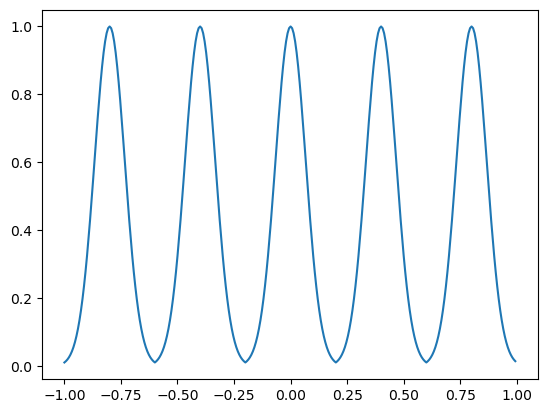

In [363]:
plt.plot(X_all.view(total_data_size).numpy(), y_all.view(total_data_size).numpy())

### MLP
Create model for regression

In [364]:
class GaussRegressionModel(nn.Module):
    def __init__(self, hidden_neuron_num):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(in_features=1, out_features=hidden_neuron_num),
            nn.ReLU(),
            nn.Linear(in_features=hidden_neuron_num, out_features=hidden_neuron_num),
            nn.ReLU(),
            nn.Linear(in_features=hidden_neuron_num, out_features=hidden_neuron_num),
            nn.ReLU(),
            nn.Linear(in_features=hidden_neuron_num, out_features=1)
        )
    def forward(self, x):
        return self.stack(x)

Train function

In [365]:
def train_model(model, X_train, y_train, loss_fn, optimizer):
    model.train()
    # 1. Forward pass
    y_pred = model(X_train)
    # 2. Calculate the loss/acc
    loss = loss_fn(y_pred, y_train)
    # 3. Optimizer zero grad
    optimizer.zero_grad() 
    # 4. Loss backward (backpropagation) 
    loss.backward()
    # 5. Optimizer step (gradient descent)
    optimizer.step()

    return loss, y_pred, y_train

Validate function

In [366]:
def evaluate_model(model, X_test, y_test, loss_fn):
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)
    return test_loss

Train cycle function

In [367]:
def do_training_cycle(model, X_tr, y_tr, X_te, y_te, loss_fn, lr=0.001, epoch_num = 1, device = "cpu"):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    X_train, y_train = X_tr.to(device), y_tr.to(device)
    X_test, y_test = X_te.to(device), y_te.to(device)
    for epoch in range(epoch_num):
        loss, predictions, y_train = train_model(model, X_train, y_train, loss_fn, optimizer)
        test_loss = evaluate_model(model, X_test, y_test, loss_fn)
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

  

Train model

In [368]:
from sklearn.model_selection import train_test_split
import copy
def increment(index, model, X_all, y_all, loss_fn, lr=0.001, epoch_num = 1, device = "cpu"):
    X = X_all[index].unsqueeze(dim=1)
    y = y_all[index].unsqueeze(dim=1)
    divider = round(X.shape[0] * 0.8)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    do_training_cycle(model, X_train, y_train, X_test, y_test, loss_fn, lr, epoch_num, device)
    return copy.deepcopy(model.state_dict())
    

In [369]:
torch.manual_seed(2)
torch.cuda.manual_seed(2)
myModel = GaussRegressionModel(32).to(device)
loss_fn = nn.MSELoss()

In [370]:
model_states = []
for increment_index in range(X_all.shape[0]):
    print(f"-- Increment {increment_index} --")
    model_states.append(increment(increment_index, myModel, X_all, y_all, loss_fn, 0.001, 1000, device))

-- Increment 0 --
Epoch: 0 | Loss: 0.60406 | Test loss: 0.33115
Epoch: 100 | Loss: 0.12257 | Test loss: 0.11404
Epoch: 200 | Loss: 0.11815 | Test loss: 0.11143
Epoch: 300 | Loss: 0.10708 | Test loss: 0.10085
Epoch: 400 | Loss: 0.05371 | Test loss: 0.05160
Epoch: 500 | Loss: 0.00193 | Test loss: 0.00322
Epoch: 600 | Loss: 0.00058 | Test loss: 0.00060
Epoch: 700 | Loss: 0.00051 | Test loss: 0.00041
Epoch: 800 | Loss: 0.00051 | Test loss: 0.00037
Epoch: 900 | Loss: 0.00051 | Test loss: 0.00037
-- Increment 1 --
Epoch: 0 | Loss: 0.46228 | Test loss: 0.24696
Epoch: 100 | Loss: 0.12502 | Test loss: 0.11573
Epoch: 200 | Loss: 0.11411 | Test loss: 0.10877
Epoch: 300 | Loss: 0.09262 | Test loss: 0.09127
Epoch: 400 | Loss: 0.04039 | Test loss: 0.04202
Epoch: 500 | Loss: 0.00421 | Test loss: 0.00698
Epoch: 600 | Loss: 0.00141 | Test loss: 0.00251
Epoch: 700 | Loss: 0.00110 | Test loss: 0.00173
Epoch: 800 | Loss: 0.00089 | Test loss: 0.00141
Epoch: 900 | Loss: 0.00075 | Test loss: 0.00115
-- Incre

In [371]:
# Make predictions on original
X = X_all.reshape(total_data_size).unsqueeze(dim=1)
y = y_all.reshape(total_data_size).unsqueeze(dim=1)

myModel.eval()
with torch.inference_mode():
    y_preds = myModel(X)

print(loss_fn(y_preds, y))

tensor(0.2546)


Load all models and show their plots

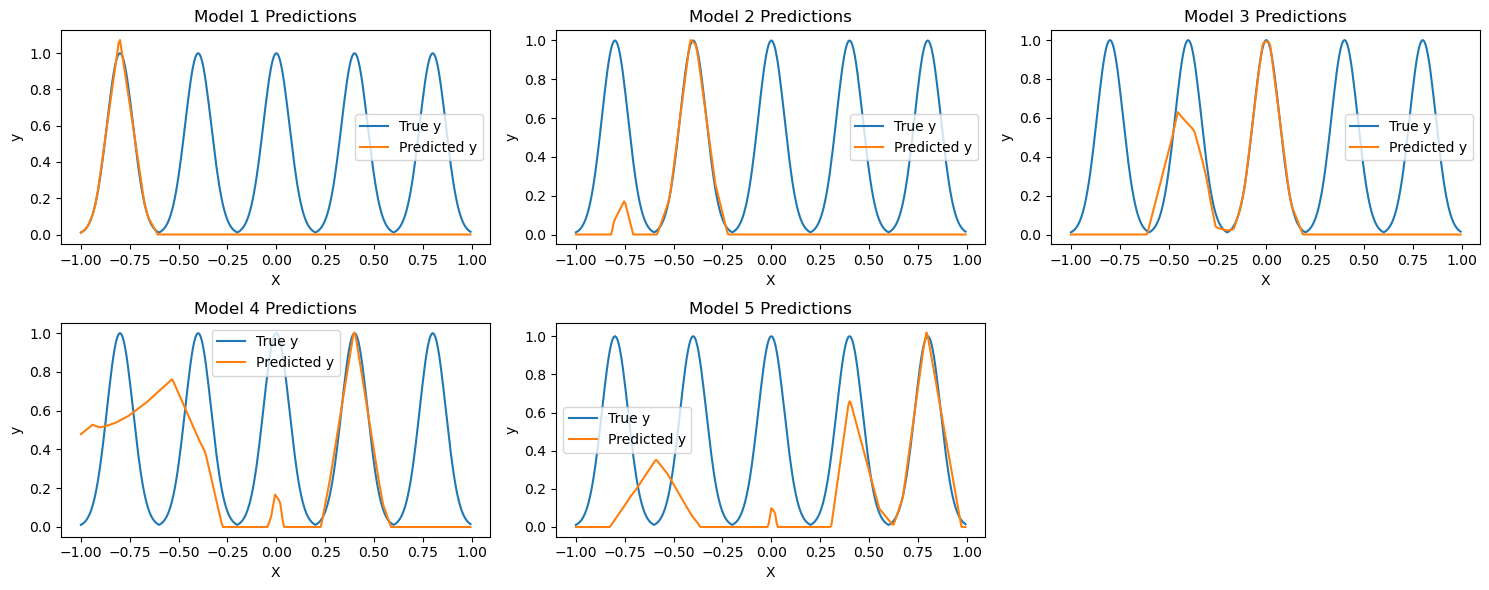

In [372]:
import math
plt.figure(figsize=(15, 3*math.ceil(len(model_states)/3)))
X = X_all.reshape(total_data_size).unsqueeze(dim=1)
y = y_all.reshape(total_data_size).unsqueeze(dim=1)
# Iterate through the models and plot predictions
for i, model_state in enumerate(model_states):
    model = GaussRegressionModel(32).to(device)
    model.load_state_dict(model_state)
    model.eval()
    with torch.inference_mode():
        y_preds = model(X)
    
    # Plot the true values and predicted values
    plt.subplot(math.ceil(len(model_states)/3), 3, i + 1) 
    plt.plot(X.numpy(), y.numpy(), label="True y")
    plt.plot(X.numpy(), torch.relu(y_preds).numpy(), label="Predicted y")
    
    # Set titles and labels
    plt.title(f"Model {i+1} Predictions")
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()

# Show all the plots
plt.tight_layout()
plt.show()

In [373]:
from torchsummary import summary
summary(myModel, (1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]              64
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              ReLU-4                   [-1, 32]               0
            Linear-5                   [-1, 32]           1,056
              ReLU-6                   [-1, 32]               0
            Linear-7                    [-1, 1]              33
Total params: 2,209
Trainable params: 2,209
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


### KAN

In [374]:
def calculate_kan_parameter_num(shape, k, G):
    """
    Calculate the number of parameters in KAN.

    Parameters:
    - shape (list): A list of integers representing the number of units in each layer.
    - G (int): Grid parameter.
    - k (int): Degree of B-splines.

    Returns:
    - int: The total number of parameters.
    """
    if len(shape) < 2:
        raise ValueError("The network must have at least two layers.")
    
    # Calculate the sum of products of consecutive layer sizes
    parameter_sum = sum(shape[i] * shape[i + 1] for i in range(len(shape) - 1))

    total_parameters = parameter_sum * (G + k)
    
    return total_parameters


In [375]:
from kan import *
kan_k = 3
kan_grid = 50
kan_shape = [1, 1]

calculate_kan_parameter_num(kan_shape, kan_k, kan_grid)

53

In [376]:
kan_model = KAN(width=kan_shape, grid=kan_grid, k=kan_k, seed=42, device=device, sp_trainable=False, sb_trainable=False)

checkpoint directory created: ./model
saving model version 0.0


In [377]:
def train_kan(model, dataset, optimizer, loss_fn, epochs):
    for epoch in range(epochs):
        model.train()
        pred = model(dataset['train_input'])
        optimizer.zero_grad()
        loss = loss_fn(pred, dataset['train_label'])
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, loss {loss:.6f}")

In [378]:
def kan_increment(index, model, X_all, y_all, epochs = 50, optimizer="LBFGS"):
    X = X_all[index]
    y = y_all[index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    kan_input = {
        'train_input': X_train,
        'train_label': y_train,
        'test_input': X_test,
        'test_label': y_test
    }
    # model.fit(kan_input, opt=optimizer, steps=epochs, lr=0.001, loss_fn=loss_fn, batch=8);
    opt = torch.optim.Adam(params = model.parameters(), lr=0.01)
    train_kan(model, kan_input, opt, loss_fn, epochs )
    return copy.deepcopy(model.state_dict())

In [379]:
X_all_unsqueezed = X_all.unsqueeze(dim=-1)
y_all_unsqueezed = y_all.unsqueeze(dim=-1)
kan_model_states = []
for increment_index in range(X_all.shape[0]):
    print(f"-- Increment {increment_index} --")
    kan_model_states.append(kan_increment(increment_index, kan_model, X_all_unsqueezed, y_all_unsqueezed, 500, "Adam"))

-- Increment 0 --
Epoch 0, loss 0.250902
Epoch 100, loss 0.005690
Epoch 200, loss 0.000110
Epoch 300, loss 0.000005
Epoch 400, loss 0.000002
-- Increment 1 --
Epoch 0, loss 0.275947
Epoch 100, loss 0.007224
Epoch 200, loss 0.000169
Epoch 300, loss 0.000009
Epoch 400, loss 0.000003
-- Increment 2 --
Epoch 0, loss 0.330087
Epoch 100, loss 0.011277
Epoch 200, loss 0.000309
Epoch 300, loss 0.000012
Epoch 400, loss 0.000002
-- Increment 3 --
Epoch 0, loss 0.418114
Epoch 100, loss 0.019282
Epoch 200, loss 0.000624
Epoch 300, loss 0.000030
Epoch 400, loss 0.000002
-- Increment 4 --
Epoch 0, loss 0.556822
Epoch 100, loss 0.035758
Epoch 200, loss 0.001545
Epoch 300, loss 0.000090
Epoch 400, loss 0.000009


In [380]:
# Make predictions on original
X = X_all.reshape(total_data_size).unsqueeze(dim=1)
y = y_all.reshape(total_data_size).unsqueeze(dim=1)

kan_model.eval()
with torch.no_grad():
    y_preds = kan_model(X)

print(loss_fn(y_preds, y))

tensor(5.0886e-05)


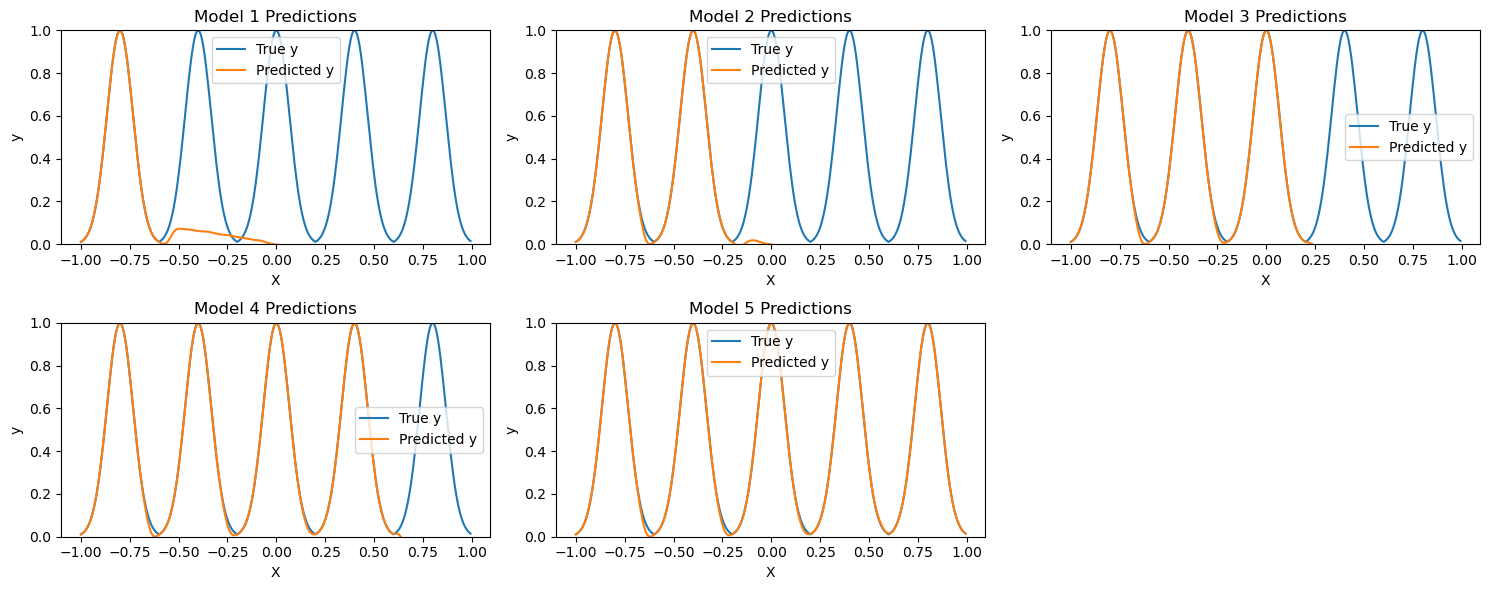

In [381]:
import math
plt.figure(figsize=(15, 3*math.ceil(len(model_states)/3)))
X = X_all.reshape(total_data_size).unsqueeze(dim=1)
y = y_all.reshape(total_data_size).unsqueeze(dim=1)
# Iterate through the models and plot predictions
for i, model_state in enumerate(kan_model_states):
    model = KAN(width=kan_shape, grid=kan_grid, k=kan_k, seed=42, device=device, auto_save = False)
    model.auto_save = false
    model.load_state_dict(model_state)
    model.eval()
    with torch.inference_mode():
        y_preds = model(X)
    
    # Plot the true values and predicted values
    plt.subplot(math.ceil(len(model_states)/3), 3, i + 1)
    plt.ylim(0.0, 1.0)
    plt.plot(X.numpy(), y.numpy(), label="True y")
    plt.plot(X.numpy(), y_preds.numpy(), label="Predicted y")
    
    # Set titles and labels
    plt.title(f"Model {i+1} Predictions")
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()

# Show all the plots
plt.tight_layout()
plt.show()

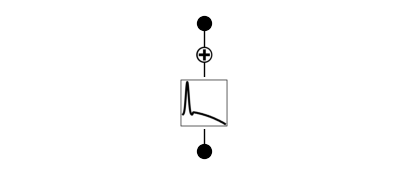

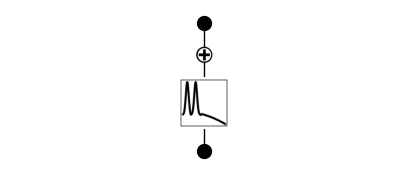

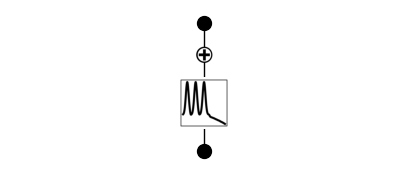

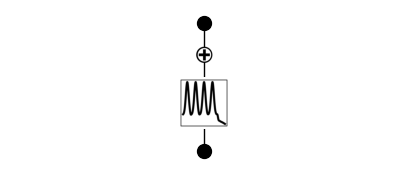

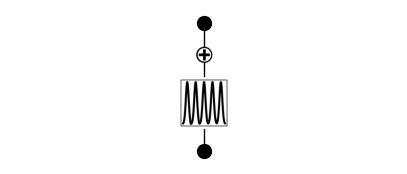

In [382]:
for i, model_state in enumerate(kan_model_states):
    model = KAN(width=kan_shape, grid=kan_grid, k=kan_k, seed=42, device=device, auto_save=False)
    model.load_state_dict(model_state)
    model.eval()
    with torch.no_grad():
        y_preds = model(X)
    
    # Plot the true values and predicted values
    model.plot()

## Symbolic regression with two features in a 3D space

### Function for generation of a Gaussian spike

In [383]:
def create_3d_gaussian_data(x_range, y_range, step, center, sigma=1.0):
    x_vals = torch.arange(x_range[0], x_range[1], step)
    y_vals = torch.arange(y_range[0], y_range[1], step)
    xx, yy = torch.meshgrid(x_vals, y_vals, indexing='ij')
    
    X = torch.stack([xx.flatten(), yy.flatten()], dim=1)  # Shape: [N, 2]

    # 2D Gaussian
    dx = X[:, 0] - center[0]
    dy = X[:, 1] - center[1]
    dist_sq = dx**2 + dy**2
    Z = torch.exp(-dist_sq / (2 * sigma**2))  # Shape: [N]

    return X, Z

### Function for 3D visualization

In [384]:
from mpl_toolkits.mplot3d import Axes3D

def plot_surfaces(X_all, y_all, title="Surface"):
    fig = plt.figure(figsize=(8, 10))
    ax = fig.add_subplot(111, projection='3d')

    num_points = int(np.sqrt(X_all.shape[0]*X_all.shape[1]))
    x = X_all[:,:,0].view(1,-1, 1).view(num_points, num_points)
    y = X_all[:,:,1].view(1,-1, 1).view(num_points, num_points)
    z = y_all.view(1, -1).view(num_points, num_points)
    ax.plot_surface(x, y, z, cmap='viridis', alpha=0.9)

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Height')
    plt.tight_layout()
    plt.show()

### Generate spikes

In [385]:
width = 6
step = 0.1
sigma = 1.0

X_all_list = []
y_all_list = []

# Define centers in a 2x2 pattern around the origin
offset = width / 2
centers = [
    (-offset, +offset),
    (+offset, +offset),
    (-offset, -offset),
    (+offset, -offset),
]

for cx, cy in centers:
    x_range = (cx - width / 2, cx + width / 2)
    y_range = (cy - width / 2, cy + width / 2)
    center = (cx, cy)

    X, y = create_3d_gaussian_data(x_range, y_range, step, center, sigma)
    X_all_list.append(X)
    y_all_list.append(y)

X_all = torch.stack(X_all_list, dim=0)
y_all = torch.stack(y_all_list, dim=0)

print(torch.unique(X_all[:,:,0].view(1,-1, 1).squeeze()))
print(X_all.shape, y_all.shape)

tensor([-6.0000, -5.9000, -5.8000, -5.7000, -5.6000, -5.5000, -5.4000, -5.3000,
        -5.2000, -5.1000, -5.0000, -4.9000, -4.8000, -4.7000, -4.6000, -4.5000,
        -4.4000, -4.3000, -4.2000, -4.1000, -4.0000, -3.9000, -3.8000, -3.7000,
        -3.6000, -3.5000, -3.4000, -3.3000, -3.2000, -3.1000, -3.0000, -2.9000,
        -2.8000, -2.7000, -2.6000, -2.5000, -2.4000, -2.3000, -2.2000, -2.1000,
        -2.0000, -1.9000, -1.8000, -1.7000, -1.6000, -1.5000, -1.4000, -1.3000,
        -1.2000, -1.1000, -1.0000, -0.9000, -0.8000, -0.7000, -0.6000, -0.5000,
        -0.4000, -0.3000, -0.2000, -0.1000,  0.0000,  0.1000,  0.2000,  0.3000,
         0.4000,  0.5000,  0.6000,  0.7000,  0.8000,  0.9000,  1.0000,  1.1000,
         1.2000,  1.3000,  1.4000,  1.5000,  1.6000,  1.7000,  1.8000,  1.9000,
         2.0000,  2.1000,  2.2000,  2.3000,  2.4000,  2.5000,  2.6000,  2.7000,
         2.8000,  2.9000,  3.0000,  3.1000,  3.2000,  3.3000,  3.4000,  3.5000,
         3.6000,  3.7000,  3.8000,  3.90

### Visualize the spikes to learn
TODO: Look into fixing the jagged edges

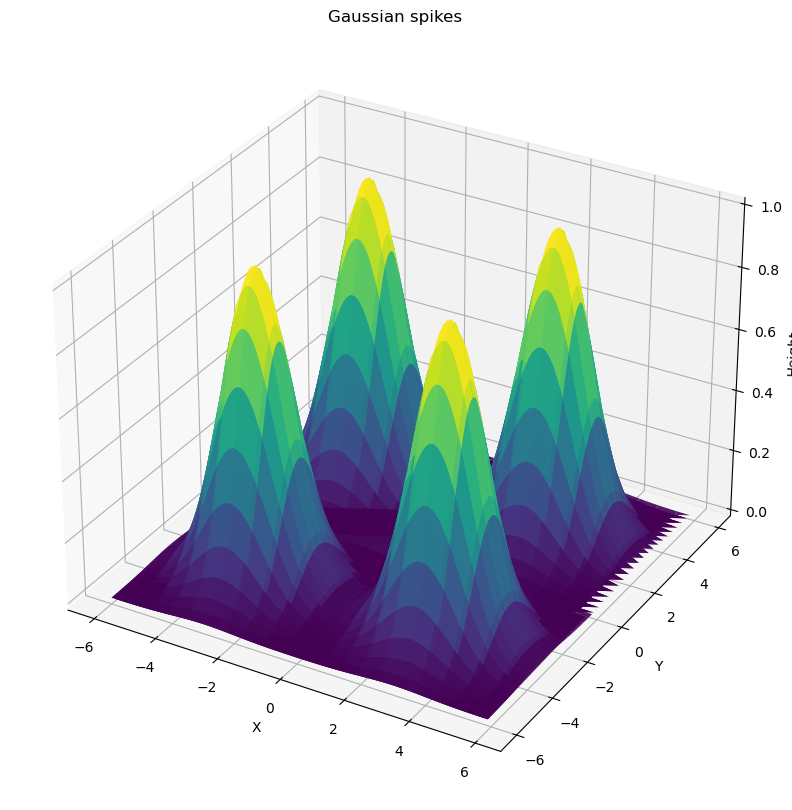

In [386]:
plot_surfaces(X_all, y_all, title=f"Gaussian spikes")

## Train MLP for the regression task

In [387]:
class Gauss3dRegressionModel(nn.Module):
    def __init__(self, hidden_neuron_num):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=hidden_neuron_num),
            nn.ReLU(),
            nn.Linear(in_features=hidden_neuron_num, out_features=hidden_neuron_num),
            nn.ReLU(),
            nn.Linear(in_features=hidden_neuron_num, out_features=hidden_neuron_num),
            nn.ReLU(),
            nn.Linear(in_features=hidden_neuron_num, out_features=1)
        )
    def forward(self, x):
        return self.stack(x)

In [388]:
torch.manual_seed(2)
torch.cuda.manual_seed(2)
my3dModel = Gauss3dRegressionModel(32).to(device)
loss_fn = nn.MSELoss()

In [389]:
model_states = []
y_all_unsqueezed = y_all.unsqueeze(-1)
for increment_index in range(X_all.shape[0]):
    print(f"-- Increment {increment_index} --")
    model_states.append(increment(increment_index, my3dModel, X_all, y_all_unsqueezed, loss_fn, 0.001, 500, device))

-- Increment 0 --
Epoch: 0 | Loss: 0.11016 | Test loss: 0.09856
Epoch: 100 | Loss: 0.01522 | Test loss: 0.01442
Epoch: 200 | Loss: 0.00277 | Test loss: 0.00276
Epoch: 300 | Loss: 0.00093 | Test loss: 0.00109
Epoch: 400 | Loss: 0.00015 | Test loss: 0.00015
-- Increment 1 --
Epoch: 0 | Loss: 0.13966 | Test loss: 0.11266
Epoch: 100 | Loss: 0.01264 | Test loss: 0.01264
Epoch: 200 | Loss: 0.00250 | Test loss: 0.00262
Epoch: 300 | Loss: 0.00067 | Test loss: 0.00077
Epoch: 400 | Loss: 0.00025 | Test loss: 0.00028
-- Increment 2 --
Epoch: 0 | Loss: 0.17621 | Test loss: 0.13493
Epoch: 100 | Loss: 0.00530 | Test loss: 0.00504
Epoch: 200 | Loss: 0.00247 | Test loss: 0.00245
Epoch: 300 | Loss: 0.00129 | Test loss: 0.00134
Epoch: 400 | Loss: 0.00083 | Test loss: 0.00087
-- Increment 3 --
Epoch: 0 | Loss: 0.25220 | Test loss: 0.15554
Epoch: 100 | Loss: 0.00878 | Test loss: 0.00839
Epoch: 200 | Loss: 0.00123 | Test loss: 0.00109
Epoch: 300 | Loss: 0.00022 | Test loss: 0.00020
Epoch: 400 | Loss: 0.000

In [390]:
# Make predictions on original
X = X_all.reshape(-1, 2).unsqueeze(dim=1)
y = y_all.reshape(-1, 1).unsqueeze(dim=1)

my3dModel.eval()
with torch.inference_mode():
    y_preds = my3dModel(X)

print(f"Loss for all training data after the last increment: {loss_fn(y_preds, y):.5f}")

Loss for all training data after the last increment: 0.04811


### Print loss for only the first increment of points across increments

In [391]:
import math
for j in range(X_all.shape[0]):
    X = X_all[j].reshape(-1, 2).unsqueeze(dim=1)
    y = y_all[j].reshape(-1, 1).unsqueeze(dim=1)
    print(f"Loss for data points in increment {j+1}")
    for i, model_state in enumerate(model_states):
        if i < j:
            continue
        model = Gauss3dRegressionModel(32).to(device)
        model.load_state_dict(model_state)
        model.eval()
        with torch.inference_mode():
            y_preds = model(X)
            loss = loss_fn(y_preds, y)
            print(f"  increment {i+1}: {loss:.5f}")


Loss for data points in increment 1
  increment 1: 0.00009
  increment 2: 0.03453
  increment 3: 0.06013
  increment 4: 0.05934
Loss for data points in increment 2
  increment 2: 0.00014
  increment 3: 0.09693
  increment 4: 0.08633
Loss for data points in increment 3
  increment 3: 0.00057
  increment 4: 0.04672
Loss for data points in increment 4
  increment 4: 0.00007


## Train KAN for regression task

In [471]:
from kan import *
kan_k = 3
kan_grid = 50
kan_shape = [2, 2, 1]

calculate_kan_parameter_num(kan_shape, kan_k, kan_grid)

318

In [472]:
kan_model = KAN(width=kan_shape, grid=kan_grid, k=kan_k, seed=2, device=device, sp_trainable=False, sb_trainable=False)

checkpoint directory created: ./model
saving model version 0.0


In [473]:
kan_model_states = []

for increment_index in range(X_all.shape[0]):
    print(f"-- Increment {increment_index} --")
    kan_model_states.append(kan_increment(increment_index, kan_model, X_all, y_all_unsqueezed, 500, "Adam"))

-- Increment 0 --
Epoch 0, loss 0.130016
Epoch 100, loss 0.101511
Epoch 200, loss 0.100506
Epoch 300, loss 0.095328
Epoch 400, loss 0.091285
-- Increment 1 --
Epoch 0, loss 0.154150
Epoch 100, loss 0.033574
Epoch 200, loss 0.027947
Epoch 300, loss 0.024951
Epoch 400, loss 0.024411
-- Increment 2 --
Epoch 0, loss 0.082335
Epoch 100, loss 0.028580
Epoch 200, loss 0.026255
Epoch 300, loss 0.025474
Epoch 400, loss 0.025231
-- Increment 3 --
Epoch 0, loss 0.613037
Epoch 100, loss 0.091265
Epoch 200, loss 0.054431
Epoch 300, loss 0.043430
Epoch 400, loss 0.036084


In [474]:
# Make predictions on original
X = X_all.reshape(-1, 2)
y = y_all.reshape(-1, 1)

kan_model.eval()
with torch.inference_mode():
    y_preds = kan_model(X)

print(f"Loss for all training data after the last increment: {loss_fn(y_preds, y):.5f}")

Loss for all training data after the last increment: 0.31538


In [475]:
for j in range(X_all.shape[0]):
    X = X_all[j].reshape(-1, 2)
    y = y_all[j].reshape(-1, 1)
    print(f"Loss for data points in increment {j+1}")
    for i, model_state in enumerate(kan_model_states):
        if i < j:
            continue
        model = KAN(width=kan_shape, grid=kan_grid, k=kan_k, seed=42, device=device, auto_save = False)
        model.auto_save = false
        model.load_state_dict(model_state)
        model.eval()
        with torch.inference_mode():
            y_preds = model(X)
            loss = loss_fn(y_preds, y)
            print(f"  increment {i+1}: {loss:.5f}")

Loss for data points in increment 1
  increment 1: 0.09601
  increment 2: 0.22227
  increment 3: 0.29494
  increment 4: 0.28478
Loss for data points in increment 2
  increment 2: 0.02461
  increment 3: 0.15543
  increment 4: 0.26272
Loss for data points in increment 3
  increment 3: 0.02489
  increment 4: 0.68156
Loss for data points in increment 4
  increment 4: 0.03245


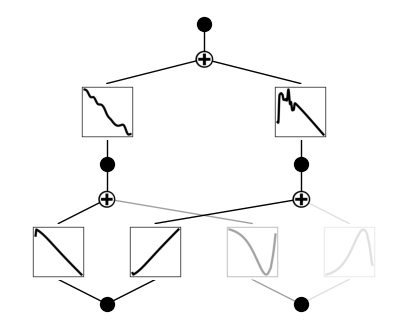

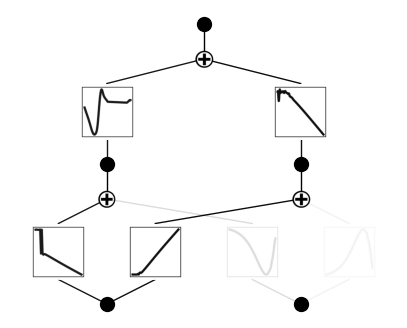

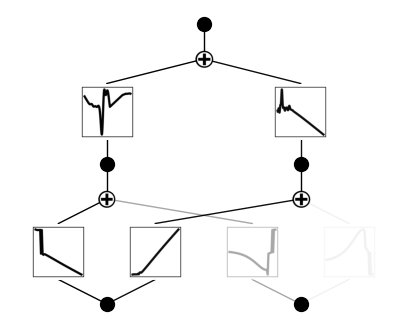

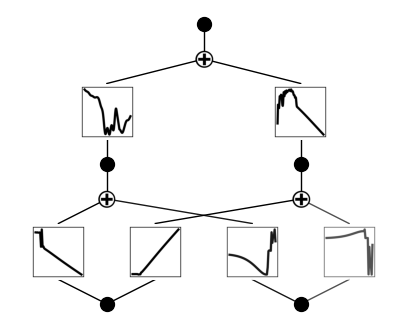

In [476]:
for i, model_state in enumerate(kan_model_states):
    model = KAN(width=kan_shape, grid=kan_grid, k=kan_k, seed=42, device=device, auto_save=False)
    model.load_state_dict(model_state)
    model.eval()
    with torch.no_grad():
        y_preds = model(X)
    
    # Plot the true values and predicted values
    model.plot()

We can see that no connection is maintained by the network between the incrementally fed data points. In addition, it tries to consider only one of the two input dimensions to produce its output, which leads to compromised accuracy.